In [1]:
from advectionGP.models import MCMCAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel
from advectionGP.kernels import EQ

import numpy as np
X = np.array([[17,18,10,10],[12,13,5,5]])
y = np.array([12,14])

boundary = ([0,0,0],[20,20,20])
k = EQ(1.0, 2.0)
sensors = FixedSensorModel(X,1)
m = Model(resolution=[100,20,20],boundary=boundary,N_feat=15,noiseSD=5.0,kernel=k,sensormodel=sensors,u=0.01,k_0=0.05)

z = np.random.randn(m.N_feat)


source = m.computeSourceFromPhi(z)
m.computeConcentration(source)

predy = m.computeObservations()
predy-y

array([ -9.87517877, -14.68206473])

In [2]:
m.computeZDistribution(y)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0.,

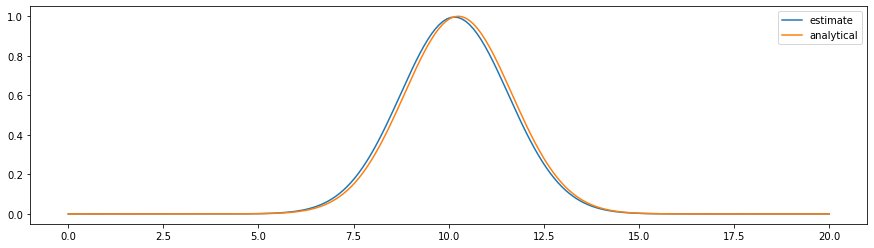

In [3]:
from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel
from advectionGP.kernels import EQ

import numpy as np

X = np.array([[17,18,10,10]])
y = np.array([12])

boundary = ([0,0,0],[20,20,20])
k = EQ(1.0, 2.0)
sensors = FixedSensorModel(X,1)
m = Model(resolution=[1000,200,200],boundary=boundary,N_feat=150,noiseSD=5.0,kernel=k,sensormodel=sensors,u=0.01,k_0=0.05)

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize()
source = np.zeros(m.resolution)
source[1,int(Nx/2)-1,int(Ny/2)-1] = 1.0
import matplotlib.pyplot as plt
%matplotlib inline
estimated_concentration = m.computeConcentration(source)

x = np.linspace(boundary[0][0],boundary[1][0],Nx)
t = ((Nt-1)/m.resolution[0])*m.boundary[1][0]
new_centre = (m.boundary[1][1]+dx)/2+m.u*t
c = np.exp(-(x-new_centre)**2/(4*m.k_0*t))

conc_snapshot = estimated_concentration[Nt-1,int(Nx/2),:].copy()
conc_snapshot/=np.sum(conc_snapshot)
conc_snapshot*=np.sum(c)
plt.figure(figsize=[15,4])
plt.plot(x,conc_snapshot,label='estimate')
plt.plot(x,c,label='analytical')
plt.legend()
#plt.xlim([10.5,12.5])

In [3]:
#m.computeSourceFromPhi()
#m.computeConcentration()
#m.computeObservations()

In [4]:
v = m.computeAdjoint(list(sensors.getHs(m))[0])

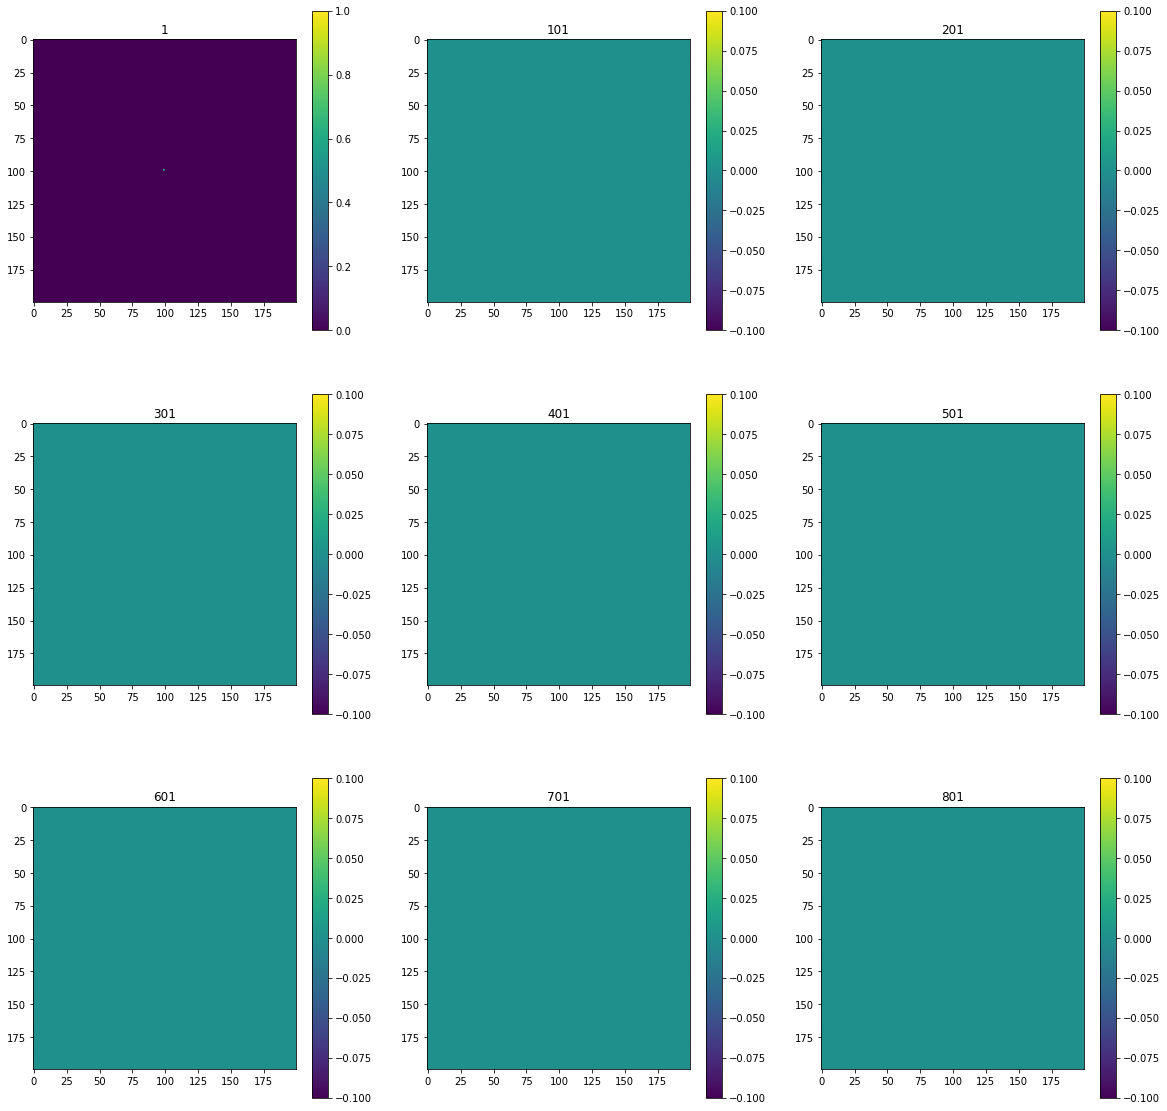

In [5]:
plt.figure(figsize=[20,20])
for i,step in enumerate(range(1,900,100)):
    plt.subplot(3,3,i+1)
    plt.imshow(source[step,:,:])
    plt.title(step)
    plt.colorbar()

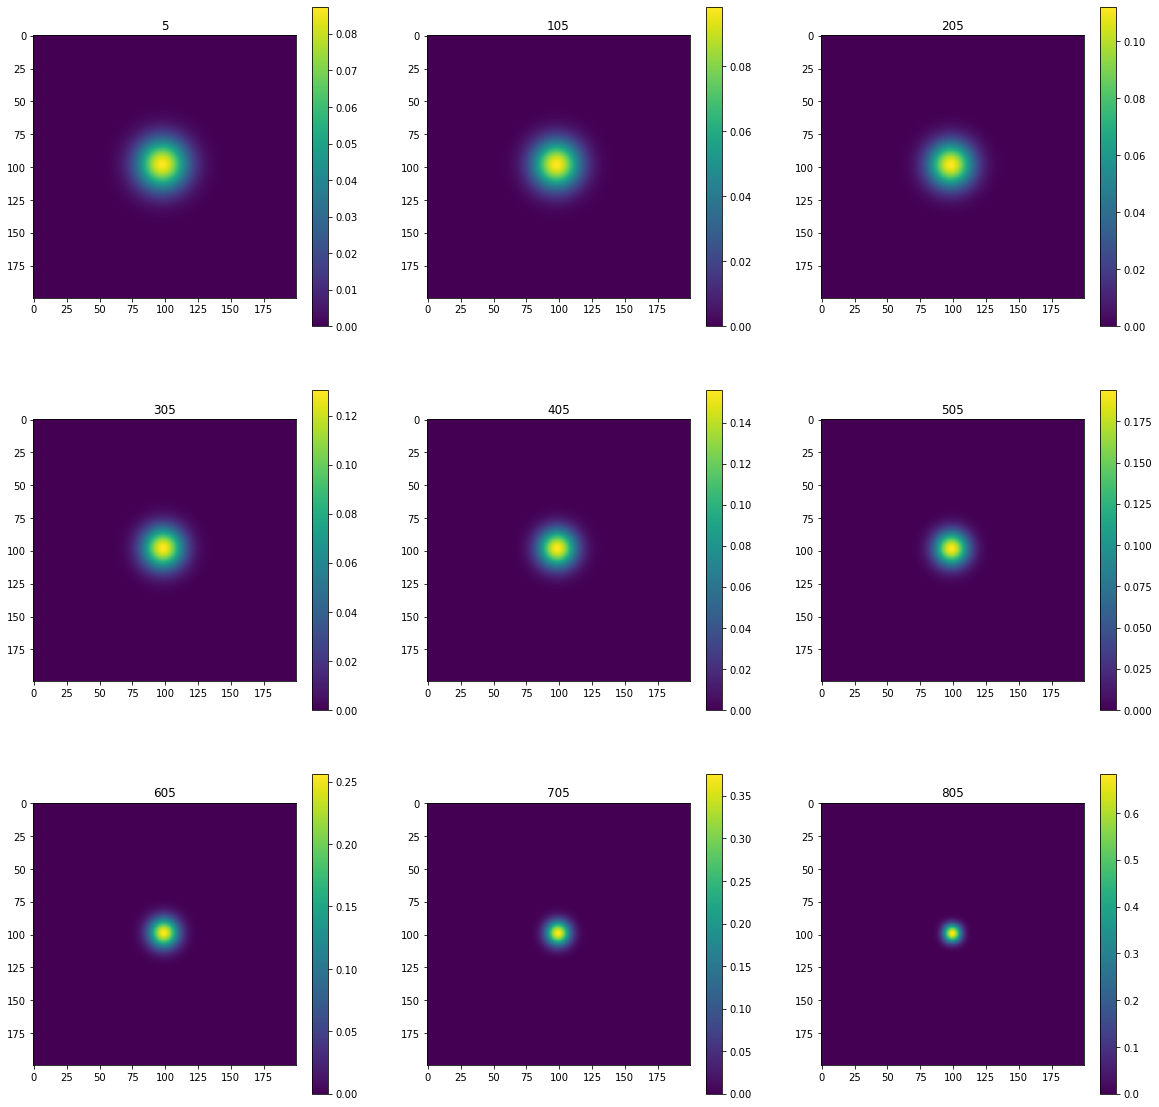

In [6]:
plt.figure(figsize=[20,20])
for i,step in enumerate(range(5,900,100)):
    plt.subplot(3,3,i+1)
    plt.imshow(v[step,:,:])
    plt.title(step)
    plt.colorbar()

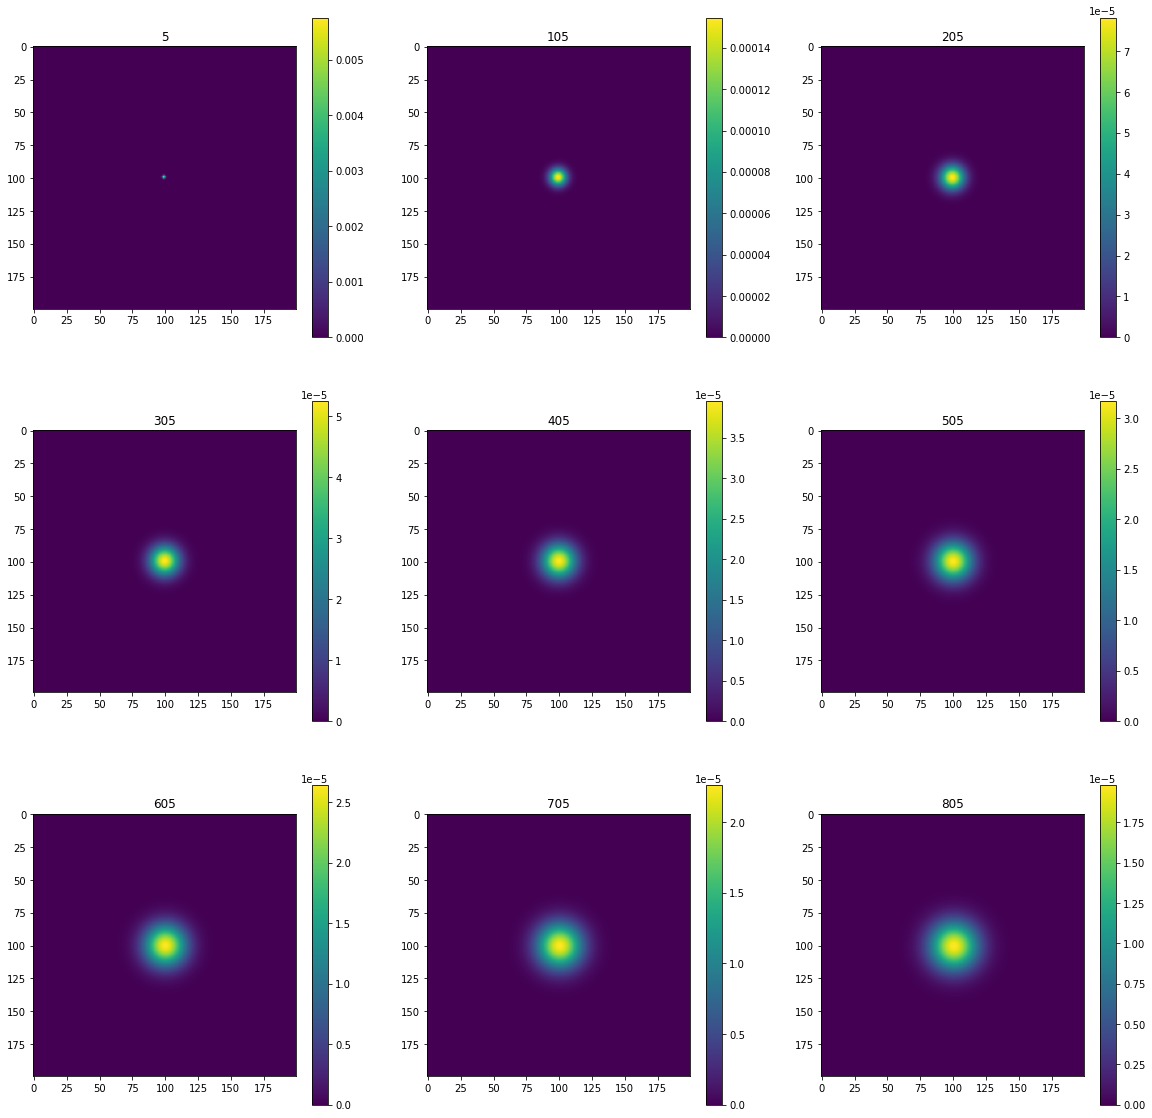

In [7]:
plt.figure(figsize=[20,20])
for i,step in enumerate(range(5,900,100)):
    plt.subplot(3,3,i+1)
    plt.imshow(m.conc[step,:,:])
    plt.title(step)
    plt.colorbar()

In [8]:
from advectionGP.models import AdvectionDiffusionModel
from advectionGP.sensors import FixedSensorModel
from advectionGP.kernels import Kernel
import numpy as np
import tensorflow as tf

class fastEQ(Kernel):
    def __init__(self,l2,sigma2):
        """
        A Exponentiated Quadratic kernel
        Arguments:
            l2 == lengthscale
            sigma2 == variance of kernel
        """
        self.l2 = l2
        self.sigma2 = sigma2
        self.W = None #need to be set by calling generateFeatures.
        self.b = None 
                
    def generateFeatures(self,N_D,N_feat):
        """
        Create a random basis for the kernel.
        Arguments:
            N_D = number of dimensions
            N_feat = number of features
        """
        self.W = np.random.normal(0,1.0,size=(N_feat,N_D))
        self.b = np.random.uniform(0.,2*np.pi,size=N_feat)
        self.N_D = N_D
        self.N_feat = N_feat
        
 
    def getPhi(self,coords):
        assert self.W is not None, "Need to call generateFeatures before computing phi."
        print("getPhi!")
        norm = 1./np.sqrt(self.N_feat)
        #c=np.sqrt(2.0)/(self.l2)
        c=1/(self.l2)
        for w,b in zip(self.W,self.b):
            phi=norm*np.sqrt(2*self.sigma2)*np.cos(c*np.einsum('i,ijkl->jkl',w,coords)+ b)
            yield phi
            
    def getPhiFast(self,coords):
        assert self.W is not None, "Need to call generateFeatures before computing phi."
        norm = 1./np.sqrt(self.N_feat)
        c=1/(self.l2)
        for i in range(len(self.W)):
            phi = norm*np.sqrt(2*self.sigma2)*tf.math.cos(np.transpose(c*m.coords,axes=[1,2,3,0])@k.W[i,:]+ self.b[i])
            yield phi

X = np.array([[17,18,10,10]])
y = np.array([12])

boundary = ([0,0,0],[20,20,20])
k = fastEQ(1.0, 2.0)
sensors = FixedSensorModel(X,1)
m = AdvectionDiffusionModel(resolution=[1000,100,100],boundary=boundary,N_feat=1,noiseSD=5.0,kernel=k,sensormodel=sensors,u=0.01,k_0=0.05)
            
#for phi,fastphi in zip(k.getPhi(m.coords),k.getPhiFast(m.coords)):
#    print(phi,fastphi)

In [9]:
%timeit list(sensors.getHs(m))

337 µs ± 37.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
H = list(sensors.getHs(m))[0]

In [13]:
%timeit m.computeAdjoint(H)

536 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [169]:
%timeit list(k.getPhiFast(m.coords))

318 ms ± 30.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [155]:
for fast,slow in zip(k.getPhiFast(m.coords),k.getPhi(m.coords)):
    print(np.max(np.abs(fast-slow)))

getPhi!
0.0
0.0
0.0
0.0


KeyboardInterrupt: 

In [145]:
import tensorflow as tf


In [147]:
import numpy as np
A = np.random.rand(1000,100,100)*100
%timeit -r 3 -n 3 np.cos(A)
%timeit -r 3 -n 3 tf.math.cos(A)

270 ms ± 4.56 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
170 ms ± 5.64 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [14]:
dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize()
np.sum(v*source)*dt*dx*dy

6.907581895087247e-05

In [8]:
dt*dx*dy

0.0002

In [9]:
np.sum(source)*dt*dx*dy

0.0002

In [15]:
m.computeObservations()

AttributeError: 'AdvectionDiffusionModel' object has no attribute 'conc'

In [ ]:
m.computeModelRegressors(sensors)

[[17.   9.5  9.5]]
850 900 95 105 95 105
